In [1]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from ipynb.fs.full.preProcess import basic_preProcess, color_preProcess, augment_contrast


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate

from keras.utils.vis_utils import plot_model

In [2]:
# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [3]:
# For Local File:
# train_dir = './train/'
# test_dir = './test/'
# train_df = pd.read_csv('./train.csv')

In [4]:
train_data_color = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          img_ca = img.copy()
          img_co = img.copy()
          img_color = color_preProcess(img_co)
          img_color_output = basic_preProcess(img_color)
          
          train_data_color.append(img_color_output)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])

        else:
          print("no image found")



xtrain_warna, xval_warna, ytrain_warna, yval_warna = train_test_split(
    train_data_color, train_warna,
    test_size=0.2, random_state=42,
    stratify=train_warna  # Ensures balanced class distribution for color labels
)

max_len = len(xtrain_warna)
for img_raw, warna in zip(xtrain_warna[:int(max_len*0.75)],ytrain_warna[:int(max_len*0.75)]):
   if warna not in [3]:
      # print(warna)
      xtrain_warna.append(augment_contrast(img_raw))
      ytrain_warna.append(warna)

In [11]:
def ColorNet(input, nb_class):
    top_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    # top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    # top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    # top_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    # top_top_conv2 = BatchNormalization()(top_top_conv2)
    # top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    # top_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    # top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    # top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    # top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv1)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5)

    top_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    # bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    # bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    # bottom_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    # bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    # bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    # bottom_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    # bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    # bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    # bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv1)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5)

    bottom_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    flatten = Flatten()(conv_output)

    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=2048, activation='relu')(FC_1)
    FC_2 = Dropout(0.5)(FC_2)
    output = Dense(units=nb_class)(FC_2)
    output = Activation("softmax")(output)

    return output

In [6]:
input_shape = (224, 224, 3)

# num_classes_jenis = len(np.unique(train_jenis))
num_classes_warna = len(np.unique(train_warna))

train_warna_categorical = to_categorical(train_warna, num_classes=num_classes_warna)
# train_jenis_categorical = to_categorical(train_jenis, num_classes=num_classes_jenis)

# ytrain_jenis = to_categorical(ytrain_jenis, num_classes=num_classes_jenis)
# yval_jenis = to_categorical(yval_jenis, num_classes=num_classes_jenis)
ytrain_warna = to_categorical(ytrain_warna, num_classes=num_classes_warna)
yval_warna = to_categorical(yval_warna, num_classes=num_classes_warna)

xtrain_warna = np.array(xtrain_warna)
xval_warna = np.array(xval_warna)
# xtrain_jenis = np.array(xtrain_jenis)
# xval_jenis = np.array(xval_jenis)

inp_color = Input(shape=input_shape)
inp_category = Input(shape=input_shape)

colorBranch = ColorNet(input=inp_color, nb_class=num_classes_warna)

print("Color model categorical labels (train_warna_categorical):", train_warna_categorical)
# print("Jenis model categorical labels (train_jenis_categorical):", train_jenis_categorical)


Color model categorical labels (train_warna_categorical): [[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [12]:
color_model = Model(inputs=inp_color,outputs=colorBranch)

In [13]:
# Train Color Model
# opt = Adam(learning_rate=0.00005)
opt = Adam(learning_rate=0.00003)

color_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

history = color_model.fit(xtrain_warna,ytrain_warna, batch_size= 16, epochs=70,validation_data=(xval_warna,yval_warna))

Epoch 1/70
59/59 [==============================] - 5s 71ms/step - loss: 0.1291 - accuracy: 0.9979 - val_loss: 0.3976 - val_accuracy: 0.9295
Epoch 2/70
59/59 [==============================] - 4s 69ms/step - loss: 0.1328 - accuracy: 0.9925 - val_loss: 0.3596 - val_accuracy: 0.9487
Epoch 3/70
59/59 [==============================] - 4s 65ms/step - loss: 0.1160 - accuracy: 0.9989 - val_loss: 0.3211 - val_accuracy: 0.9551
Epoch 4/70
59/59 [==============================] - 4s 64ms/step - loss: 0.1576 - accuracy: 0.9851 - val_loss: 1.5588 - val_accuracy: 0.8077
Epoch 5/70
59/59 [==============================] - 4s 65ms/step - loss: 0.1425 - accuracy: 0.9957 - val_loss: 0.3210 - val_accuracy: 0.9487
Epoch 6/70
59/59 [==============================] - 4s 64ms/step - loss: 0.1071 - accuracy: 0.9957 - val_loss: 0.4102 - val_accuracy: 0.9231
Epoch 7/70
59/59 [==============================] - 4s 64ms/step - loss: 0.1326 - accuracy: 0.9915 - val_loss: 0.3594 - val_accuracy: 0.9423
Epoch 8/70
59

KeyboardInterrupt: 

30/30 [==============================] - 0s 12ms/step - loss: 0.1248 - accuracy: 0.9968
Loss and metrics for each output: [0.12482977658510208, 0.9968017339706421]
Total Test Loss: 0.12482977658510208
Color Accuracy: 0.9968017339706421
5/5 [==============================] - 0s 29ms/step - loss: 0.2835 - accuracy: 0.9551
Loss and metrics for each output: [0.28353774547576904, 0.9551281929016113]
Total Vall Loss: 0.28353774547576904
Val Color Accuracy: 0.9551281929016113


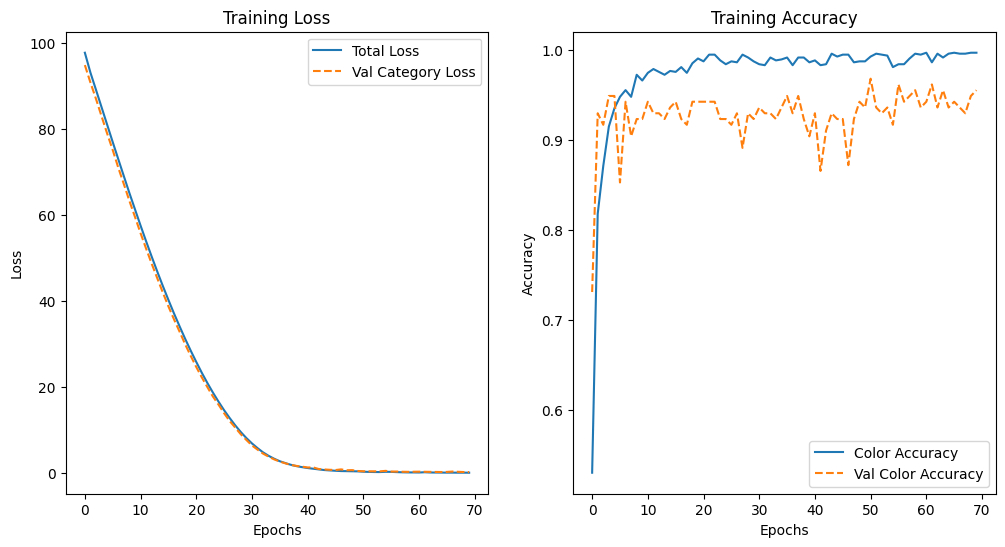

In [9]:
# View Color Model Metrics
score = color_model.evaluate(xtrain_warna,ytrain_warna)
print("Loss and metrics for each output:", score)
print('Total Test Loss:', score[0])
print('Color Accuracy:', score[1])

score = color_model.evaluate(xval_warna,yval_warna)
print("Loss and metrics for each output:", score)
print('Total Vall Loss:', score[0])
print('Val Color Accuracy:', score[1])

totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Color Accuracy')
plt.plot(range(totall), history.history['val_accuracy'], label='Val Color Accuracy', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [10]:
color_model.save('./models/color.h5', include_optimizer=True)